# hii.rc.usf.edu user-based filesystems usage report

In [30]:
import datetime
import os
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests

%matplotlib inline
pd.options.mode.chained_assignment = None

GB = 2**30
TB = 2**40

usermap_date = os.environ.get('USERMAP_DATE', '2017-07')
usermap_yaml = f'http://depot.epi.usf.edu/src/countskm/hpcreport/data/usermap-{usermap_date}.yaml'

date = os.environ.get('DATESTAMP', datetime.datetime.today().strftime('%Y-%m'))
date

'2017-07'

## Establish /hii/work or /home as filesystem and set variations

In [31]:
report = os.environ.get('REPORT', 'fs-home')

if report == 'fs-home':
    filesystem = '/home'
    path_offset = 2    
    data_prefix='http://depot.epi.usf.edu/src/countskm/hpcreport/data/find-home'
    
elif report == 'fs-hii-work':
    filesystem = '/hii/work'
    path_offset = 3
    data_prefix='http://depot.epi.usf.edu/src/countskm/hpcreport/data/find-hii-work'
    
report

## Create user to group mapping structure

In [32]:
usermap_data = yaml.load(requests.get(usermap_yaml).text)

usermap = {}
usermap_data

for group, users in usermap_data.items():
    for user in users:
        usermap[user] = group

## Read in the pipe separated find output of the filesystem


In [43]:
df = pd.read_csv(f'{data_prefix}-{date}.psv.bz2', sep='|', dtype=str)
df = df.dropna()
df.bytes = df.bytes.apply(int)

In [44]:
df.head()

,path,inode,number_links,owner,group,ctime,atime,mtime,bytes,perms
0,/hii/work/r/rchen7/annotation.txt,14055716,1,rchen7,rchen7,2016-09-07,2016-11-01,2016-09-07,205283851,0640
1,/hii/work/r/rchen7/cor_expvsobs_review.R,22351900,1,rchen7,rchen7,2016-11-03,2016-11-03,2016-11-03,1658,0660
2,/hii/work/r/rchen7/project/microbiome/curlset_...,30563418,1,rchen7,rchen7,2017-06-08,2017-06-08,2017-06-08,600,0660
3,/hii/work/r/rchen7/project/microbiome/curlset_...,30563403,1,rchen7,rchen7,2017-06-08,2017-06-08,2017-06-08,254,0770
4,/hii/work/r/rchen7/project/microbiome/curlfile...,30563402,1,rchen7,rchen7,2017-06-08,2017-06-12,2017-06-08,253,0770


In [45]:
df = df[(df.path != f'{filesystem}/.control') & (~df.path.str.startswith(f'{filesystem}/.snapshots'))]

In [46]:
df = df[df.path.apply(lambda x: len(x.split('/')) > path_offset)]

## Extract the group, filename, and file extension creating additional columns

In [47]:
df['user'] = df.path.apply(lambda x: x.split('/')[path_offset+1])
df['filename'] = df.path.apply(lambda x: x.split('/')[-1])
df['file_ext'] = df.path.apply(lambda x: os.path.splitext(x)[-1])

In [48]:
df['group'] = df.user.apply(lambda x: usermap.get(x, 'unknown'))

## Show the head to get an idea of the structure

In [49]:
df.head()

,path,inode,number_links,owner,group,ctime,atime,mtime,bytes,perms,user,filename,file_ext
0,/hii/work/r/rchen7/annotation.txt,14055716,1,rchen7,hii-uva,2016-09-07,2016-11-01,2016-09-07,205283851,0640,rchen7,annotation.txt,.txt
1,/hii/work/r/rchen7/cor_expvsobs_review.R,22351900,1,rchen7,hii-uva,2016-11-03,2016-11-03,2016-11-03,1658,0660,rchen7,cor_expvsobs_review.R,.R
2,/hii/work/r/rchen7/project/microbiome/curlset_...,30563418,1,rchen7,hii-uva,2017-06-08,2017-06-08,2017-06-08,600,0660,rchen7,curlset_MP189_set.bsh,.bsh
3,/hii/work/r/rchen7/project/microbiome/curlset_...,30563403,1,rchen7,hii-uva,2017-06-08,2017-06-08,2017-06-08,254,0770,rchen7,curlset_MP189.bsh,.bsh
4,/hii/work/r/rchen7/project/microbiome/curlfile...,30563402,1,rchen7,hii-uva,2017-06-08,2017-06-12,2017-06-08,253,0770,rchen7,curlfile_MP189.bsh,.bsh


## Create columns to levels in the path (/home/{fi}/{user}/{level-1}/{level-2}/{level-3})

In [50]:
def custom_split(x, level):
    offset = path_offset + 1 # to strip off the user-based prefix
    elements = x.split('/')
    if level + offset >= len(elements):
        return None
    else:
        return elements[level + offset]

for level in (1, 2, 3):
    df['level-' + str(level)] = df.path.apply(lambda x: custom_split(x, level))

In [51]:
df_by_group_user_and_level = df.groupby(['group', 'user', 'level-1', 'level-2'])

## Display the top 20 level-3 folder usage in GB 

In [52]:
(df_by_group_user_and_level.bytes.sum() / GB).round(decimals=2).sort_values(ascending=False).head(20)

group      user        level-1          level-2                      
hii-uva    rchen7      project          mp175                            4451.83
hiibaylor  mcwong      TEDDYSamData     Jobs.Split.7                     3539.05
                                        Jobs.Split.5                     3488.54
                                        Jobs.Split.8                     3371.86
                                        Jobs.Split.9                     3322.80
                                        Jobs.Split.10                    3275.89
                                        Jobs.Split.6                     3004.50
                                        Jobs.Split.3                     2926.95
                                        Jobs.Split.4                     2885.42
                                        Jobs.Split.1                     2604.79
                                        Jobs.Split.0                     2561.73
                                       

## Split into groups and show total usage in TB by group

In [53]:
dfg = df.groupby('group')

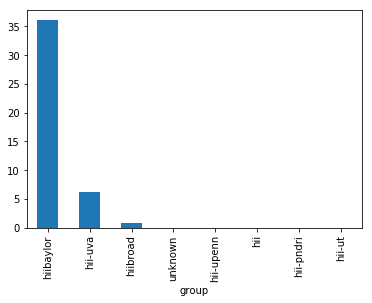

In [54]:
(dfg.bytes.sum() / TB).sort_values(ascending=False).plot.bar()

## Show number of files by file extension (blank indicates no extension)

In [55]:
df_by_file_ext = df.groupby('file_ext')

In [56]:
df_by_file_ext.path.count().sort_values(ascending=False).head(20)

file_ext
.txt        229080
.out        197958
.sh         197603
.html       131073
.log        112333
.bz2         99896
.py          95498
.lz          66165
.tsv         45459
.biom        24741
.fna         24497
.uc          24429
.err         22328
.json        22125
.species     22049
.fq          16750
             15733
.fqun2       12334
.fqun1       12334
.markers     11549
Name: path, dtype: int64

## Show usage in TB by file extension (blank indicates no extension)

In [57]:
(df_by_file_ext.bytes.sum().sort_values(ascending=False) / TB).round(decimals=2).head(20)

file_ext
.lz         16.18
.bz2        15.38
.dose        2.86
.gz          2.73
.species     1.78
.tar         0.86
.markers     0.86
.txt         0.55
.jf          0.29
.lz4         0.28
.fna         0.26
.fq          0.21
.bt2l        0.19
.hg38        0.15
.RData       0.14
.hg19        0.14
.info        0.04
.bed         0.03
.json        0.03
             0.03
Name: bytes, dtype: float64